## COVID Detection using X-Ray with EfficientNet

### Importing Required Libraries & Data

In [2]:
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from IPython.core.display import display, HTML
import os

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.applications.imagenet_utils import preprocess_input
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

In [6]:
!pip install -U efficientnet
import efficientnet.keras as efficientNet

In [8]:
global_durations=[]
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.threshold=threshold 
        self.factor=factor 
        self.model=model
        self.patience=patience 
        self.stop_patience=stop_patience
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.initial_epoch=initial_epoch 
        self.batches=batches
        self.durations=[]
        best_weights=self.model.get_weights()       
        print(f' Starting training using base model { model_name}')            

    def on_train_begin(self, logs=None):
        print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration'))
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        print('Training is completed')
        print(self.durations)
        print(msg, (0,255,0), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')   
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  
        later=time.time()
        duration=later-self.now 
        self.durations.append(duration)
        global_durations.append(duration)
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr=lr
        v_loss=logs.get('val_loss')  
        acc=logs.get('accuracy')  
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: 
            monitor='accuracy'
            if acc>self.highest_tracc:               
                self.highest_tracc=acc 
                LRA.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    self.count=0 
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)                 
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1                  
        else: 
            monitor='val_loss'
            if v_loss< self.lowest_vloss: 
                self.lowest_vloss=v_loss                
                LRA.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: 
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor                    
                    self.stop_count=self.stop_count + 1 
                    self.count=0 
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) 
                else: 
                    self.count =self.count +1        
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        if self.stop_count> self.stop_patience - 1: 
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience}'
            print(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True 
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True 
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans

In [8]:
train_txt = pd.read_csv('/kaggle/input/covidx-cxr2/train.txt', sep=" ", header=None)
train_txt.columns= ["Sl.no","File_Name","Status","Source"]
train_txt.head()

,Sl.no,File_Name,Status,Source
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [9]:
train_txt.drop(["Sl.no","Source"], axis=1, inplace=True)

In [10]:
test_txt= pd.read_csv('/kaggle/input/covidx-cxr2/test.txt', sep=" ", header=None)
test_txt.columns= ["Sl.no","File_Name","Status","Source"]
test_txt.head()

,Sl.no,File_Name,Status,Source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [11]:
test_txt.drop(["Sl.no","Source"], axis=1, inplace=True)

In [12]:
destination_pth= '/kaggle/input/covidx-cxr2/test/'
test_txt['File_Name'] = destination_pth + test_txt['File_Name']

In [14]:
destination_pth= '/kaggle/input/covidx-cxr2/train/'
train_txt['File_Name'] = destination_pth+train_txt['File_Name']

In [15]:
train_txt['Status'].value_counts()

positive    15994
negative    13992
Name: Status, dtype: int64

In [16]:
neg = train_txt.Status[train_txt.Status.eq("negative")].sample(2158).index
pos = train_txt.Status[train_txt.Status.eq("positive")].sample(2158).index 

train_txt = train_txt.loc[neg.union(pos)]

In [17]:
train_txt.shape

(4316, 2)

### Model Training

In [18]:
train_df, valid_df=train_test_split(train_txt, test_size=0.2, stratify=train_txt["Status"], random_state=123)

In [19]:
data_gen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [20]:
train_df

,File_Name,Status
3255,/kaggle/input/covidx-cxr2/train/364aa43b-3693-...,negative
14324,/kaggle/input/covidx-cxr2/train/b9866e78-1b04-...,negative
6998,/kaggle/input/covidx-cxr2/train/9f12306f-aeae-...,negative
16262,/kaggle/input/covidx-cxr2/train/A750765-12-31-...,positive
6067,/kaggle/input/covidx-cxr2/train/87d989b3-c8ed-...,negative
...,...,...
9239,/kaggle/input/covidx-cxr2/train/e20c5b46-c709-...,negative
10488,/kaggle/input/covidx-cxr2/train/2e974d90-0e16-...,negative
17758,/kaggle/input/covidx-cxr2/train/A469587-12-30-...,positive
21045,/kaggle/input/covidx-cxr2/train/A827232-12-31-...,positive


In [21]:
valid_df

,File_Name,Status
10310,/kaggle/input/covidx-cxr2/train/1202ef51-061c-...,negative
9348,/kaggle/input/covidx-cxr2/train/e4dce044-ebd8-...,negative
12324,/kaggle/input/covidx-cxr2/train/6a078738-03df-...,negative
26148,/kaggle/input/covidx-cxr2/train/A965275-12-31-...,positive
12153,/kaggle/input/covidx-cxr2/train/5e79685b-7bcc-...,negative
...,...,...
27706,/kaggle/input/covidx-cxr2/train/A665943-01-15-...,positive
28042,/kaggle/input/covidx-cxr2/train/A654492-01-08-...,positive
26378,/kaggle/input/covidx-cxr2/train/A728722-12-24-...,positive
20445,/kaggle/input/covidx-cxr2/train/A701295-02-13-...,positive


In [22]:
import os
print( os.path.abspath("valid_df"))

/kaggle/working/valid_df


In [23]:
train_generator=data_gen.flow_from_dataframe(
dataframe=train_df,
directory="/kaggle/working/",
x_col="File_Name",
y_col="Status",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

valid_generator=data_gen.flow_from_dataframe(
dataframe=valid_df,
directory="/kaggle/working/",
x_col="File_Name",
y_col="Status",
subset="validation",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

test_gen=ImageDataGenerator(rescale=1./255.)
test_generator=test_gen.flow_from_dataframe(
dataframe=test_txt,
directory="/kaggle/working/",
x_col="File_Name",
y_col="Status",
batch_size=32,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(256,256))

Found 2589 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [24]:
base_model = efficientNet.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

16809984/16804768 [==============================] - 2s 0us/step


In [25]:
for layer in base_model.layers:
    layer.trainable = False

## Adding components to optimise 

In [26]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(base_model.input,predictions)

## Feed your GRID SEARCH values 

In [27]:
model_final.compile(SGD(lr=.001),loss='binary_crossentropy',metrics=['accuracy'])

## GRID SEARCH 

In [28]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

In [32]:
results = {}
gs_lrs = [0.0001, 0.001, 0.01, 0.1]
gs_optimizers = ['adam', 'sgd', 'sgdm']
for l in gs_lrs:
    for gs_optimizer in gs_optimizers:
        if gs_optimizer == 'adam':
            opt = Adam(lr = l)
        elif gs_optimizer == 'sgdm':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.9, nesterov=True)
        elif gs_optimizer == 'sgd':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.0, nesterov=True)


        base_model = efficientNet.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')
        for layer in base_model.layers:
            layer.trainable = False
            
        x = base_model.output
        x = Flatten()(x)
        x = Dense(1024, activation="relu")(x)
        x = Dropout(0.5)(x)
        predictions = Dense(1, activation="sigmoid")(x)
        model_final = Model(base_model.input,predictions)
        
        model_final.compile('rmsprop',loss='binary_crossentropy',metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
        lr=0.001
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])


        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

patience = 1
stop_patience = 10
factor = 0.5

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("imagenet.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    time_callback
]

epochs = 4
history = model_final.fit(train_generator, validation_data=valid_generator, epochs=epochs, callbacks=callbacks, verbose=1)
results[(gs_optimizer,l)] = history.history['val_accuracy'][-1]

In [29]:
import pandas as pd
results = {('adam', 0.0001): 0.9537037014961243, ('sgd', 0.0001): 0.9444444179534912, ('sgdm', 0.0001): 0.9398148059844971, ('adam', 0.001): 0.9398148059844971, ('sgd', 0.001): 0.9490740895271301, ('sgdm', 0.001): 0.9537037014961243, ('adam', 0.01): 0.9398148059844971, ('sgd', 0.01): 0.9259259104728699, ('sgdm', 0.01): 0.9398148059844971, ('adam', 0.1): 0.9490740895271301, ('sgd', 0.1): 0.9490740895271301, ('sgdm', 0.1): 0.9166666865348816}
ser = pd.Series(list(results.values()),
                  index=pd.MultiIndex.from_tuples(results.keys()))
df = ser.unstack().fillna(0)
df.shape
# (10, 27)

(3, 4)

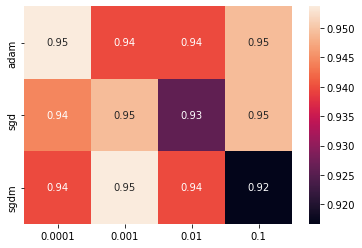

In [30]:
import seaborn as sns
sns.heatmap(df,annot=True);

In [ ]:
def plot_learning_rates(results):
    Adam =[]
    SGD = []
    SGDM = []
    
    for k,v in results.items():
        if(k[0] == 'adam'):
            Adam.append([k[1],v])
        if(k[0] == 'sgd'):
            SGD.append([k[1],v])
        if(k[0] == 'sgdm'):
            SGDM.append([k[1],v])   
    
    lrs = [x[0] for x in sorted(Adam, key = lambda x: x[0])]
    Adam = [x[1] for x in sorted(Adam, key = lambda x: x[0])]
    SGD = [x[1] for x in sorted(SGD, key = lambda x: x[0])]
    SGDM = [x[1] for x in sorted(SGDM, key = lambda x: x[0])]
      
    print(lrs, Adam, SGD, SGDM)
  
    plt.style.use('fivethirtyeight')
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(20,8))
    
    axes[0].plot(range(len(lrs)),Adam,'r',label= 'Validation Accuracy')
    axes[0].set_title('Adam')
    axes[0].set_xticks(range(len(lrs)))
    axes[0].set_xticklabels(lrs)
    axes[0].set_xlabel('Learning Rate')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].legend()  
    
    axes[1].plot (range(len(lrs)),SGD,'r',label= 'Validation Accuracy')
    axes[1].set_title('SGD')
    axes[1].set_xticks(range(len(lrs)))
    axes[1].set_xticklabels(lrs)    
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].legend() 

    axes[2].plot (range(len(lrs)),SGDM,'r',label= 'Validation Accuracy')
    axes[2].set_title('SGDM')
    axes[2].set_xticks(range(len(lrs)))
    axes[2].set_xticklabels(lrs)     
    axes[2].set_xlabel('Learning Rate')
    axes[2].set_ylabel('Validation Accuracy')
    axes[2].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

## Plotting results for GRID SEARCH

In [ ]:
plot_learning_rates(results)

## Model Training

In [33]:
history = model_final.fit_generator(train_generator, validation_data = valid_generator, steps_per_epoch = 81, callbacks=callbacks, epochs = 4)

Epoch 1/4
81/81 [==============================] - 81s 889ms/step - loss: 0.4010 - accuracy: 0.8272 - val_loss: 0.1672 - val_accuracy: 0.9167
Epoch 2/4
81/81 [==============================] - 40s 492ms/step - loss: 0.1805 - accuracy: 0.9256 - val_loss: 0.1442 - val_accuracy: 0.9444
Epoch 3/4
81/81 [==============================] - 39s 488ms/step - loss: 0.1505 - accuracy: 0.9406 - val_loss: 0.1313 - val_accuracy: 0.9491
Epoch 4/4
81/81 [==============================] - 39s 477ms/step - loss: 0.1342 - accuracy: 0.9505 - val_loss: 0.1699 - val_accuracy: 0.9352

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


### Model Validation & Prediction

In [34]:
model_final.evaluate_generator(generator=valid_generator,steps=81)

[0.16993533074855804, 0.9351851940155029]

In [35]:
valid_df

,File_Name,Status
10310,/kaggle/input/covidx-cxr2/train/1202ef51-061c-...,negative
9348,/kaggle/input/covidx-cxr2/train/e4dce044-ebd8-...,negative
12324,/kaggle/input/covidx-cxr2/train/6a078738-03df-...,negative
26148,/kaggle/input/covidx-cxr2/train/A965275-12-31-...,positive
12153,/kaggle/input/covidx-cxr2/train/5e79685b-7bcc-...,negative
...,...,...
27706,/kaggle/input/covidx-cxr2/train/A665943-01-15-...,positive
28042,/kaggle/input/covidx-cxr2/train/A654492-01-08-...,positive
26378,/kaggle/input/covidx-cxr2/train/A728722-12-24-...,positive
20445,/kaggle/input/covidx-cxr2/train/A701295-02-13-...,positive


In [36]:
model_final.evaluate_generator(generator=test_generator,steps=81)

[0.1765783727169037, 0.9350000023841858]

In [37]:
pred=model_final.predict_generator(test_generator)

In [38]:
len(pred)

400

In [1]:
# Prediction for Test Data
preds=pred

NameError: name 'pred' is not defined

In [ ]:
test_txt['Status'].value_counts()

In [ ]:
times = time_callback.times

In [ ]:
def tr_plot(tr_data, training_times, start):
    #Plot the training and validation data
    t_accuracy=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    count=len(t_accuracy)+ start
    Epochs=[]
    for i in range (start, count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start)
    vc_label='best epoch= '+ str(index_acc + 1+ start)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,t_accuracy,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    cumulative_train = [x/60 for x in training_times]
    cumulative_train = [sum(cumulative_train[0:i+1]) for i in range(0,len(cumulative_train))]
    print(cumulative_train)
    axes[2].plot (Epochs,cumulative_train,'r',label= 'Epoch Training Times')
    axes[2].set_title('Epoch Training Times')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Training Time (in minutes)')
    axes[2].legend()    
    plt.tight_layout
    plt.show()

In [ ]:
time_callback.times

In [ ]:
tr_plot(history, time_callback.times, 0)

In [ ]:
from sklearn.metrics import auc

print_code=0
y_pred=model_final.predict(test_generator)
print(y_pred)
new = y_pred[:, 0]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.labels, new)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print(auc_keras)

### Plotting Model Loss & Accuracy

In [ ]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

### Model Performance Analysis

In [ ]:
test_generator.class_indices

In [ ]:
test_txt['Status'][test_txt['Status']=='positive']=1.0
test_txt['Status'][test_txt['Status']=='negative']=0.0

In [ ]:
test_txt['Status'].astype('float')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, preds))
mat = confusion_matrix(test_generator.classes, preds)
print('Classification Report')
target_names = ['Negative', 'Positive']
print(classification_report(test_generator.classes, preds, target_names=target_names))

In [ ]:
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

### Checking Model Predictions

In [ ]:
# Picking out a Test Sample
print(test_txt['Status'][350])

In [ ]:
pred_out=[]
for i in range(400):
    pred_out.append(i)
print(preds[pred_out])
for i in test_txt['Status']:
    print(i)

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image= image.load_img(test_txt['File_Name'][350]
                               ,target_size =(256,256))
test_image

In [ ]:
preds[350]

### Validation of Predictions

In [ ]:
# We are taking a sample of 4 Positive & Negative Images
#The predicted images will be printed below

positive_img=[]
negative_img=[]
positive_img.append(test_txt['File_Name'][60])
positive_img.append(test_txt['File_Name'][79])
positive_img.append(test_txt['File_Name'][138])
positive_img.append(test_txt['File_Name'][141])
negative_img.append(test_txt['File_Name'][287])
negative_img.append(test_txt['File_Name'][252])
negative_img.append(test_txt['File_Name'][253])
negative_img.append(test_txt['File_Name'][243])
imgs =[]
for i in positive_img:
    imgs.append(i)
for i in negative_img:
    imgs.append(i)

In [ ]:
# Model generated predictions for above Images
preds[[60,79,138,141,287,252,253,243]]

In [ ]:
# Visualization of the above selected Images
plt.figure()
images=[]

#subplot(r,c) provide the no. of rows and columns

for i in range(len(imgs)):
    it_image = plt.imread(imgs[i]) 
    images.append(it_image)
f, arr = plt.subplots(2,4,figsize=(19,10)) 
arr[0,0].imshow(images[0],cmap='gray')
arr[0,1].imshow(images[1],cmap='gray')
arr[0,2].imshow(images[2],cmap='gray')
arr[0,3].imshow(images[3],cmap='gray')
arr[1,0].imshow(images[4],cmap='gray')
arr[1,1].imshow(images[5],cmap='gray')
arr[1,2].imshow(images[6],cmap='gray')
arr[1,3].imshow(images[7],cmap='gray')
arr[0,0].title.set_text('Positive')
arr[0,1].title.set_text('Positive')
arr[0,2].title.set_text('Positive')
arr[0,3].title.set_text('Positive')
arr[1,0].title.set_text('Negative')
arr[1,1].title.set_text('Negative')
arr[1,2].title.set_text('Negative')
axarr[1,3].title.set_text('Negative')
plt.show()